<br> <b>Rajput</b>, Rehan Razzaque 
<br> <b>Hmaied</b>, Oumaima

# Distributed optimization algorithms
The goal of this notebook is to work on distributed optimization algorithms, which are the foundation for large scale analytics and machine learning. Specifically, we will focus on the details of stochastic gradient descent (SGD). To do so, we will work on a simple regression problem, where we will apply SGD to minimize a loss function, as defined for the problem at hand. Please note that the emphasis of this notebook is **not** on the machine learning part.

Next, an outline of the steps we will follow in this Notebook:

* Breif introduction to linear regression
* Implementation of serial algorithms: from Gradient Descent, to Stochastic Gradient Descent
* Implementation of distributed algorithms with Apache Spark


# Libraries used:

##### Numpy
##### seaborn
##### Matplotlib
##### scipy
##### scikit-learn
##### PySpark

### Initialization code

In [37]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression

## A simple example: linear regression
Let’s see briefly how to use gradient descent in a simple least squares regression setting. Asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. That is, we have:

$$x = \begin{bmatrix}x_1 \\ x_2 \\ \cdots \\ x_m\end{bmatrix}, y = \begin{bmatrix}y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix}$$

We approximate $y_i$ by:

$$ f_{\theta}(x_i) = \theta_1 + \theta_2 x_i$$

Define the loss function for the simple linear least squares regression as follows:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

Now, let's use scikit learn to create a regression problem. A few notes are in order:

* The call to ```make_regression``` essentially generates samples for a regression problem
* The call to ```stats.linegress``` calculates a linear least-squares regression for two sets of measurements

This means we have a sort of "basline" to experiment with our SGD implementation.

14.5151694796 -0.106823564161


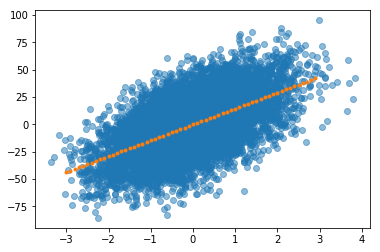

In [38]:
x, y = make_regression(n_samples = 10000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept,_,_,_ = stats.linregress(x,y)
print(slope,intercept)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')


## Batch gradient descent
Before delving into SGD, let's take a simpler approach. Assume that we have a vector of paramters $\theta$ and a loss function $J(\theta)$, which we want to minimize. The loss function we defined above has the form:

$$ J(\theta) = \sum_{i=1}^{m} J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set, such as the one we generated above. The batch gradient descent algorithm, starts with some initial feasible parameter $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J(\theta^{(t)}) = \theta^{(t)} - \eta \sum_{i=1}^{m} \nabla_{\theta} J_i(\theta^{(t)}) $$

where $t$ is an iteration index, and $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a **single update**, we need to calculate the gradient **using the entire dataset**. This can be very inefficient for large datasets, and it is the goal of this Notebook to insist on this aspect.

In code, the main loop for batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
```

For a given number of iterations (also called epochs) $n_{e}$ , we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. Batch gradient descent is guaranteed to converge to the global minimum for convex loss surfaces and to a local minimum for non-convex surfaces.

<div class="alert alert-warning">
<b>NOTE:</b> Who computes the gradient?
<br>
<br>
Given a loss function $J(\theta)$, the gradient with respect to paramters $\theta$ must be derived manually. In other words, given the expression of $J(\theta)$, pencil and paper are required to derive the analytical form of its gradient. Then this expression can be plugged into our code.

Recently, machine learning libraries have adopted the techniques of **automatic differentiation**, which eliminate this tedious and error prone step. Given a loss function $J(\theta)$, such libraries automatically compute the gradient.
</div>


For the linear regression case, let's derive the update step for gradient descent. Recall that we have defined:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

$$f_\theta(x_i) = \theta_1 + \theta_2 x_i$$

So we have that:

$$ \nabla_\theta J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (\theta_1 + \theta_2 x_i - y_i)^2 $$

If we explicit the partial derivatives of the gradient, we have:

$$\frac{\partial J(\theta)}{\partial \theta_1} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i)$$
$$\frac{\partial J(\theta)}{\partial \theta_2} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i) x_i$$

So now we can explicit the update rules for the two model parameters:

$$ \theta_1^{(t+1)} = \theta_1^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i)$$

$$ \theta_2^{(t+1)} = \theta_2^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i) x_i$$


### Using matrix notation
Now, before writing some code, let's see how can we simplify the above expressions using matrices. Note that this is not only useful for working on a more compact notation, but it helps reason about efficient computations using libraries such as numpy, which we will use extensively.

We firstly expressed our prediction as: $f_\theta (x_i) = \theta_1 + \theta_2 x_i$. Let's introduce a surrogate dimension for our input set $x$, such that:

$$x = 
\begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix}
$$

where we define, with a small abuse of notation, $x_i = \begin{bmatrix} 1 & x_{i}\end{bmatrix}$. Also, let's define vector $\theta = \begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix}$. 

Then, we can rewrite $f_\theta(x_i) = x_i \theta = \begin{bmatrix} 1 & x_{i}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} = \theta_1 + \theta_2 x_i$.

Let's use this notation to rewrite our gradients in matrix form.


$\nabla_\theta J(\theta) =  \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{m} (x_i \theta - y_i) x_i^T =$


$= x^T (x \theta - y) =$


$= \begin{bmatrix} 1 & 1 & \cdots & 1 \\ x_1 & x_2 & \cdots & x_m \end{bmatrix} 
\Bigg( \begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} - 
\begin{bmatrix} y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix} \Bigg)$

### Numpy arrays
With the work we did above, we can now cast everything into numpy arrays, which are efficient, and for which an efficient implementation of vector and matrix operations exists. Specifically, above we used the traditional matrix notation, where we manipulate column vectors. Hence, we express matrix operations (namely matrix products) using the traditional "row-by-column" approach.

In numpy, we avoid this formalism by using dot product operations. So, given two column vectors:
$$a= \begin{bmatrix} a_1 \\ a_2 \\ \cdots \\ a_{m}\end{bmatrix} b= \begin{bmatrix} b_1 \\ b_2 \\ \cdots \\ b_{m}\end{bmatrix}$$
we have that $a b^T = a \cdot b = a_1 b_1 + a_2 b_2 + \cdots + a_m b_m$, where $\cdot$ is the symbol we use for dot product.

<div class="alert alert-block alert-info">
<strong>Part 1.</strong> Implement our own version of Gradient Descent, as a serial algorithm.

Tasks:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, we generate input data according to the cell above, that use scikitlearn.
<br>

The output of our cell contains the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

In [39]:
def gradient_descent(x,y,b,w,lr,iters=1000,eps=0): # arguments
    error_1 = np.finfo('float').max # initializing the error to maximum float value 
    loss = np.zeros([1,iters]) # loss matrix for all the iterations
    grad = np.zeros([2,iters]) # gradient values for each iteration
    x = x.reshape(len(x),1) # reshaping x and y values to proper column vectors
    y = y.reshape(len(y),1)
    X_m = np.append(np.ones((len(x),1)),x,axis=1) # adding the identity column to the x matrix 
    ret_params= np.zeros([2,iters])  # parameter values to be returned
    for i in np.arange(iters):  
        param = np.array([b,w]).reshape(2,1) # creating a theta vector 
        f = X_m.dot(param) # IMPORTANT calculating 'f'. Notice the use of the whole X_m matrix 
        loss[:,i] = (0.5 * np.sum(np.square(f-y)))/len(x) # IMPORTANT calculating loss. Notice the use of the whole 'y' vector.
        grad[:,i] = (X_m.T.dot(f-y)).reshape(2) # IMPORTANT calculating gradient. Notice the use of whole X_m matrix and y vector.
        b = b - lr*grad[0,i] # updating the parameters
        w = w - lr*grad[1,i]
        ret_params[:,i] = np.array([b,w]).reshape(2) # putting the updated values in the parameter matrix to be returned
        if( np.abs(loss[:,i] - error_1) <= eps): # checking the marginal improvement on the loss
            break
        error_1 = loss[:,i]
    return b,w,loss,grad,ret_params

In [40]:
%%time
iterations = 50

gd_intercept,gd_slope,gd_loss,gd_grad,gd_parameters = gradient_descent(x,y,0.1,10,np.power(0.1,5),iters=iterations,eps=0)
print("Values obtained by Gradient Descent")
print(gd_intercept,gd_slope)
print("Values obtained by Linear Regression")
print(intercept,slope)

Values obtained by Gradient Descent
-0.10735395575 14.4885881888
Values obtained by Linear Regression
-0.106823564161 14.5151694796
CPU times: user 852 ms, sys: 64 ms, total: 916 ms
Wall time: 219 ms


<div class="alert alert-block alert-info">
<strong>Part 2.</strong> Plotting the regression line, along with the training data, given the coefficients $\theta$ that we have obtained with Gradient Descent.
</div>

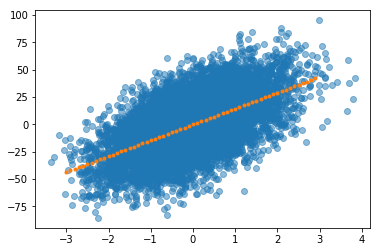

In [41]:
reg_line = np.vectorize(lambda x: x * gd_slope + gd_intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,reg_line(grid), '.')

In [42]:
np.array([1,x[0]]).dot(np.array([gd_intercept,gd_slope]))

10.449358744064838

<div class="alert alert-block alert-info">
<strong>Part 3.</strong> Plotting a 3D surface representing: on the x,y axes the parameter values, on the z axis the loss value. Additionally, plot the trajectory of the loss function on the 3D surface, using the history collected in the gradient_descent function.

Finally, we plot a contour projection of the 3D surface, along with the corresponding projection of the trajectory followed by our Gradient Descent algorithm.
</div>

In [45]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Text(0.5,0,'Loss')

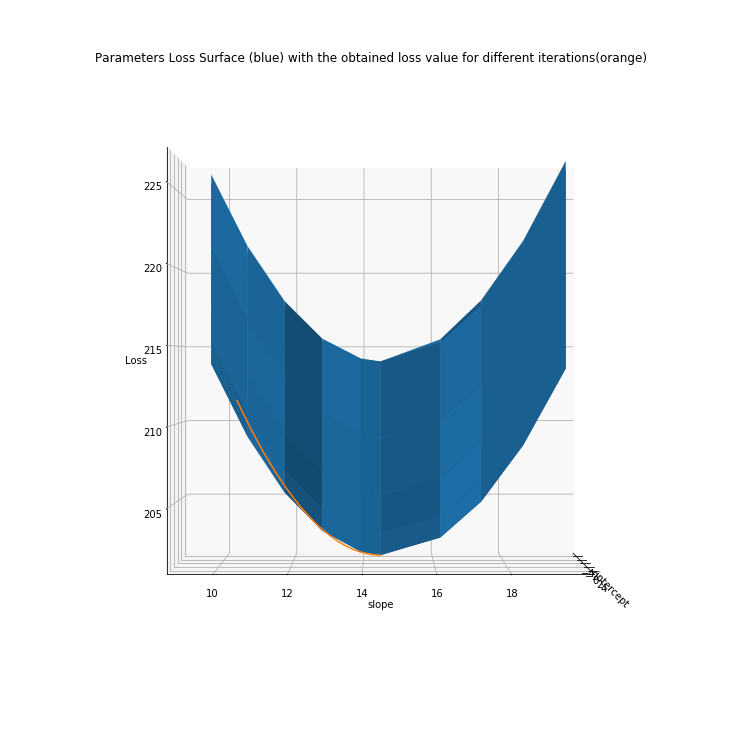

In [58]:
SIZE = 10
x = x.reshape(len(x),1) # reshaping x and y values to proper row vectors
y = y.reshape(len(y),1)
X_m = np.append(np.ones((len(x),1)),x,axis=1)
param_0 = np.linspace(gd_intercept - SIZE/2,gd_intercept + SIZE/2,SIZE) #creating a linear space around our final values
param_0[SIZE//2] = gd_intercept
param_1 = np.linspace(gd_slope - SIZE/2,gd_slope + SIZE/2,SIZE)
param_1[SIZE//2] = gd_slope
gd_3d_loss = np.empty((SIZE,SIZE))
for i in np.arange(SIZE):
    for j in np.arange(SIZE):
        param_3d = np.array([param_0[i],param_1[j]]).reshape(2,1)
        gd_3d_loss[i,j] = (0.5 * np.sum(np.square(X_m.dot(param_3d)-y)))/len(x)
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.view_init(0,0) # these angles can be changed for a different view.
ax.plot_surface(param_0,param_1,gd_3d_loss)
ax.plot(np.squeeze(gd_parameters[0,:]),np.squeeze(gd_parameters[1,:]),np.squeeze(gd_loss))
ax.set_title('Parameters Loss Surface (blue) with the obtained loss value for different iterations(orange)')
ax.set_xlabel('intercept')
ax.set_ylabel('slope')
ax.set_zlabel('Loss')

201.509492095


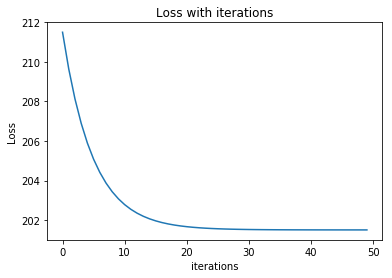

In [47]:
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),gd_loss.reshape(iterations))
plt.xlabel('iterations')
plt.ylabel('Loss')
print(gd_loss[0,-1])

<div class="alert alert-block alert-info">
<strong>Part 4.</strong> Plotting the path the gradient takes from its initial to its final position.

This is a two dimensional plot (because our parameter vector has size 2), with a point for each gradient value, and a line connecting the points.
</div>

Text(0,0.5,'Parameters')

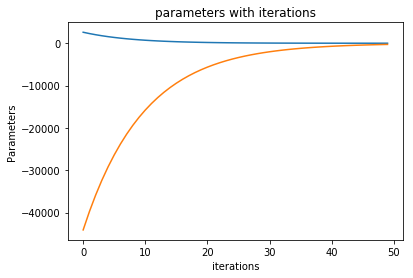

In [48]:
plt.title('parameters with iterations')
plt.plot(np.arange(iterations),gd_grad[0,:],gd_grad[1,:])
plt.xlabel('iterations')
plt.ylabel('Parameters')

Text(0,0.5,'Slope')

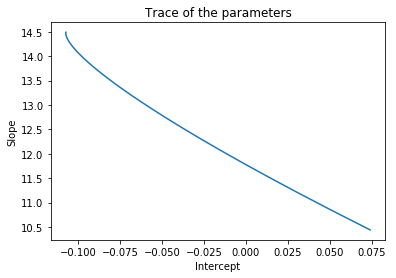

In [49]:
plt.title('Trace of the parameters')
plt.plot(gd_parameters[0,:],gd_parameters[1,:])
plt.xlabel('Intercept')
plt.ylabel('Slope')

Note that the values of parameters are moving from right to left.

## Stochastic Gradient Descent

The gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, computing $\nabla_\theta J(\theta)$ can be computationally challenging: as noted above, we must process every data point before making a single step (hence the name "batch"). 

An alternative approach to alleviate such computational costs is the Stochastic Gradient Descent method: essentially, the idea is to update the parameters $\theta$ sequentially (one data point at the time), with every observation $x_i, y_i$. Following the same notation we used for Gradient Descent, the following expression defines how to update parameters, while processing one data point at the time:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J_i(\theta^{(t)}) $$


The stochastic gradient approach allows us to start making progress on the minimization problem one step at the time. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent.

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we are satisfied with an **approximation** for the solution to our optimization problem. 

A full recipe for stochastic gradient descent follows:

```python 
for i in range(n_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order.

<div class="alert alert-block alert-info">
<strong>Part 5.</strong> Implement our version of Stochastic Gradient Descent, as a serial algorithm.

Tasks:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, we generate input data according to the cell above, that use scikitlearn.
<br>

    
The output of the cell contains the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

In [51]:
def stochastic_gradient_descent(x,y,b,w,lr,iterations= 1000,eps=np.power(0.1,20)): # arguments
    error_1 = np.finfo('float').max # initializing the error to maximum float value 
    loss = np.zeros([1,iterations]) # loss matrix for all the iterations
    grad = np.zeros([2,iterations]) # gradient values for each iteration
    x = x.reshape(len(x),1) # reshaping x and y values to proper row vectors
    y = y.reshape(len(y),1)
    X_m = np.append(np.ones((len(x),1)),x,axis=1) # adding the identity column to the x matrix 
    ret_params= np.zeros([2,iterations])  # parameter values to be returned
    for i in np.arange(iterations):  
        for j in np.arange(len(x)):
            param = np.array([b,w]).reshape(2,1) # creating a theta vector 
            f = X_m[j].dot(param) # IMPORTANT calculating 'f'. Notice the use of just one row of X_m
            l = 0.5 * np.sum(np.square(f-y[j])) # IMPORTANT calculating loss. Notice the use of just one element of y
            g = (X_m[j].reshape(1,2).T.dot(f-y[j])).reshape(2) # IMPORTANT calculating gradient. Notice the use of just one row of X_m and one element of y
            loss[:,i] += l # calculating loss
            grad[:,i] += g # calculating gradient
            b = b - lr*g[0] # updating the parameters
            w = w - lr*g[1]
            if( np.abs(l - error_1) <= eps): # checking the marginal improvement on the loss
                ret_params[:,i] = np.array([b,w]).reshape(2) # putting the updated values in the parameter matrix to be returned
                return b,w,loss,grad,ret_params
            error_1 = loss[:,i]
        ret_params[:,i] = np.array([b,w]).reshape(2)
        loss[:,i] /= len(x)
    return b,w,loss,grad,ret_params

In [52]:
%%time
iterations =50
sgd_intercept,sgd_slope,sgd_loss,sgd_grad,sgd_parameters = stochastic_gradient_descent(x,y,-1,11,\
                                                                                       np.power(0.1,5),\
                                                                                       iterations=iterations)

print("Values obtained by Stochastic Gradient Descent")
print(sgd_intercept,sgd_slope)
print("Values obtained by Linear Regression")
print(intercept,slope)


Values obtained by Stochastic Gradient Descent
-0.116881153441 14.4865962472
Values obtained by Linear Regression
-0.106823564161 14.5151694796
CPU times: user 12.5 s, sys: 320 ms, total: 12.8 s
Wall time: 12.5 s


Text(0,0.5,'Slope')

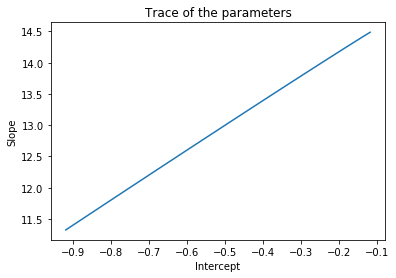

In [53]:
plt.title('Trace of the parameters')
plt.plot(sgd_parameters[0,:],sgd_parameters[1,:])
plt.xlabel('Intercept')
plt.ylabel('Slope')

Please note that the parameters' values are moving from left to right

Text(0.5,0,'Loss')

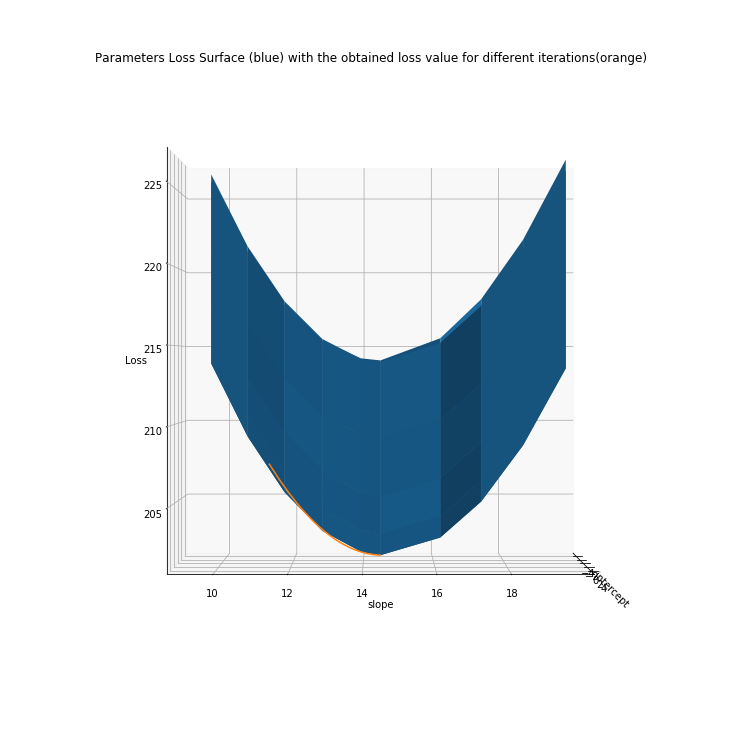

In [95]:
SIZE = 10
x = x.reshape(len(x),1) # reshaping x and y values to proper column vectors
y = y.reshape(len(y),1)
X_m = np.append(np.ones((len(x),1)),x,axis=1)
param_0 = np.linspace(sgd_intercept - SIZE/2,sgd_intercept + SIZE/2,SIZE)
param_0[SIZE//2] = sgd_intercept
param_1 = np.linspace(sgd_slope - SIZE/2,sgd_slope + SIZE/2,SIZE)
param_1[SIZE//2] = sgd_slope
sgd_3d_loss = np.empty((SIZE,SIZE))
for i in np.arange(SIZE):
    for j in np.arange(SIZE):
        param_3d = np.array([param_0[i],param_1[j]]).reshape(2,1)
        sgd_3d_loss[i,j] = (0.5 * np.sum(np.square(X_m.dot(param_3d)-y)))/len(x)
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.view_init(0,0) # these angles can be changed for a different view.
ax.plot_surface(param_0,param_1,sgd_3d_loss)
ax.plot(np.squeeze(sgd_parameters[0,:]),np.squeeze(sgd_parameters[1,:]),np.squeeze(sgd_loss))
ax.set_title('Parameters Loss Surface (blue) with the obtained loss value for different iterations(orange)')
ax.set_xlabel('intercept')
ax.set_ylabel('slope')
ax.set_zlabel('Loss')

Text(0,0.5,'Loss')

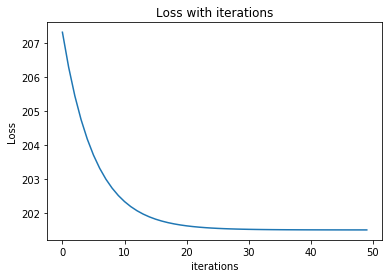

In [61]:
#iterations*=len(x)
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),sgd_loss.reshape(iterations))
plt.xlabel('iterations')
plt.ylabel('Loss')

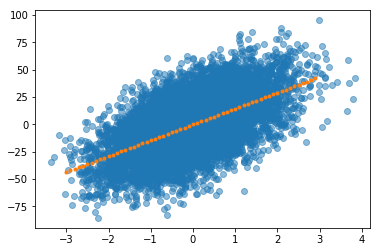

In [62]:
sreg_line = np.vectorize(lambda x: x * sgd_slope + sgd_intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,reg_line(grid), '.')

Text(0,0.5,'Parameters')

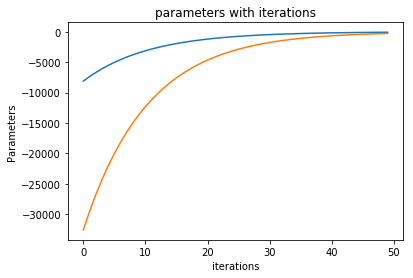

In [63]:
plt.title('parameters with iterations')
plt.plot(np.arange(iterations),sgd_grad[0,:],sgd_grad[1,:])
plt.xlabel('iterations')
plt.ylabel('Parameters')

We thought about two ways of implementing the stochastic gradient descent algorithm.

1. Where one iteration is equivalent to an epoch in which all the values in our data set are evaluated. The implementation above corresponds to this method.

2. Second method, where one iteration is equivalent to the evaluation of one point in our data set. Below is an example of such implementation. 

In [64]:
### A variant of stochastic gradient descent in which we one iteration corresponds to evaluating gradient descent on one value
def stochastic_gradient_descent2(x,y,b,w,lr,iterations= 1000,eps=np.power(0.1,10)): # arguments
    error_1 = np.finfo('float').max # initializing the error to maximum float value
    #iterations *= len(x)
    loss = np.zeros([1,iterations]) # loss matrix for all the iterations
    grad = np.zeros([2,iterations]) # gradient values for each iteration
    x = x.reshape(len(x),1) # reshaping x and y values to proper row vectors
    y = y.reshape(len(y),1)
    #x/=len(x)
    #y/=len(y)
    X_m = np.append(np.ones((len(x),1)),x,axis=1) # adding the identity column to the x matrix 
    ret_params= np.zeros([2,iterations])  # parameter values to be returned
    for i in np.arange(iterations):  
        param = np.array([b,w]).reshape(2,1) # creating a theta vector 
        f = X_m[i%len(x)].dot(param) # IMPORTANT calculating f. Notice the use of just one row of X_m. The modulus is taken w.r.t to the lenght of x in order to avoid index overflow.
        loss[:,i] = 0.5 * np.sum(np.square(f-y[i%len(x)]))# IMPORTANT calculating loss. Notice the use of just one element of y
        grad[:,i] = (X_m[i%len(x)].reshape(1,2).T.dot(f-y[i%len(x)])).reshape(2)# IMPORTANT calculating gradient. Notice the use of just one row of X_m and one element of y
        b = b - lr*grad[0,i] # updating the parameters
        w = w - lr*grad[1,i]
        ret_params[:,i] = np.array([b,w]).reshape(2) # putting the updated values in the parameter matrix to be returned
        #if( np.abs(loss[:,i] - error_1) <= eps): # checking the marginal improvement on the loss
        #    break
        #error_1 = loss[:,i]
    return b,w,loss,grad,ret_params

Values obtained by Stochastic Gradient Descent 2
-0.918934640358 11.3257662867
Values obtained by Linear Regression
-0.106823564161 14.5151694796
CPU times: user 324 ms, sys: 8 ms, total: 332 ms
Wall time: 319 ms


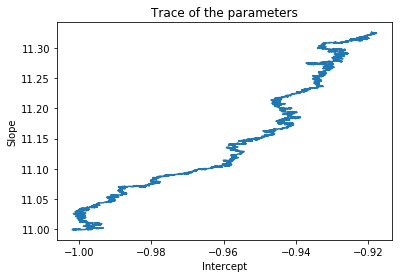

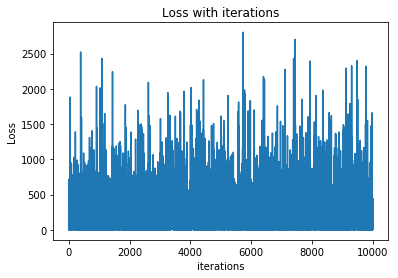

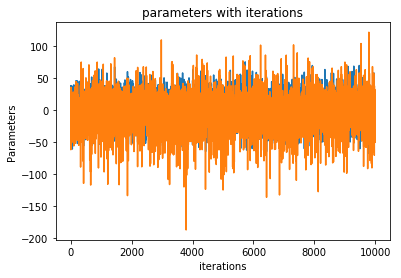

In [66]:
%%time
iterations =10000
sgd2_intercept,sgd2_slope,sgd2_loss,sgd2_grad,sgd2_parameters = stochastic_gradient_descent2(x,y,-1,11,\
                                                                                       np.power(0.1,5),\
                                                                                       iterations=iterations)

print("Values obtained by Stochastic Gradient Descent 2")
print(sgd2_intercept,sgd2_slope)
print("Values obtained by Linear Regression")
print(intercept,slope)

plt.figure()
plt.title('Trace of the parameters')
plt.plot(sgd2_parameters[0,:],sgd2_parameters[1,:])
plt.xlabel('Intercept')
plt.ylabel('Slope')


plt.figure()
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),sgd2_loss.reshape(iterations))
plt.xlabel('iterations')
plt.ylabel('Loss')



plt.figure()
plt.title('parameters with iterations')
plt.plot(np.arange(iterations),sgd2_grad[0,:],sgd2_grad[1,:])
plt.xlabel('iterations')
plt.ylabel('Parameters')



As we can see, this implementation is faster than the other one but it gave fluctuated values for loss and parameters. From now on, whenever we refer to SGD, we refer to the first implementation.

## Mini-batch Stochastic Gradient Descent

Mini-batch gradient descent is a trade-off between stochastic gradient descent and batch gradient descent.  In mini-batch gradient descent, the cost function (and therefore gradient) is averaged over a small number of samples, which is what we call the mini-batch, and that we denote by $mb$.  This is opposed to the SGD batch size of 1 sample, and the BGD size of all the training samples. 

Let's use the notation we introduced above to rewrite the gradients in matrix form for the mini-batch variant:

$\nabla_\theta J(\theta) =  \frac{1}{2 mb} \sum_{i=1}^{mb} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{mb} (x_i \theta - y_i) x_i^T =$


$= x_{mb}^T (x_{mb} \theta - y_{mb})$


What’s the benefit of doing it this way?  First, it smooths out some of the noise in SGD, but not all of it, thereby still allowing the “kick” out of local minimums of the cost function.  Second, the mini-batch size is still small, thereby keeping the performance benefits of SGD.





<div class="alert alert-block alert-info"> 
<strong>Part 6.</strong> Implement our version of Mini-batch Stochastic Gradient Descent, as a serial algorithm.

Tasks:

<ul>
    <li> Define a function to extract mini-batches from the training data.
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, we generate input data according to the cell above, that use scikitlearn.
<br>


The output of the cell contains the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

We use a function to calculate the starting and the last index for a single batch of elements. However, there's just one caveat. When we arrive at the last elements. If the number of elements remaining is smaller than the batch size. The function just takes all the elements (in which case, the batch is smaller than the predefined batch size). This usually happens when the batch size is not a simple multiple of the total number of elements.

In [67]:
#param 'i' is the index number of the current iterations
#param batch_length is self explanatory
#param length is the length of the dataset
def getBatchIndex(i,batch_length,length):
    start = int((i*batch_length)%length) # the batch starting index
    end = int(((i+1)*batch_length)%length) # the batch last index
    if(end < start): # avoiding index overflow
        end = int(length)
    return start,end

In [68]:
def mb_gradient_descent(x,y,b,w,lr,iterations=1000,eps=0,batch_length = 0.1*len(x)): # arguments
    error_1 = np.finfo('float').max # initializing the error to maximum float value 
    loss = np.zeros([1,iterations]) # loss matrix for all the iterations
    grad = np.zeros([2,iterations]) # gradient values for each iteration
    x = x.reshape(len(x),1) # reshaping x and y values to proper row vectors
    y = y.reshape(len(y),1)
    X_m = np.append(np.ones((len(x),1)),x,axis=1) # adding the identity column to the x matrix 
    ret_params= np.zeros([2,iterations])  # parameter values to be returned
    for i in np.arange(iterations):
        internal_iterations = int(len(x)/batch_length) if (len(x)%batch_length == 0) else int(len(x)/batch_length)+1 # IMPORTANT. Calculating the number of slices when the data set is divided into batches.
        for j in np.arange(internal_iterations):
            start,end = getBatchIndex(j,batch_length,len(x))#IMPORTANT Getting the start and the end index for the batch
            param = np.array([b,w]).reshape(2,1) # creating a theta vector 
            f = X_m[start:end].dot(param)#IMPORTANT calculating f. Notice the use of batch starting and ending indices.
            l = (0.5 * np.sum(np.square(f-y[start:end])))# IMPORTANT calculating loss.  Notice the use of batch starting and ending indices.
            g = (X_m[start:end].T.dot(f-y[start:end])).reshape(2) # IMPORTANT calculating gradient.  Notice the use of batch starting and ending indices.
            loss[:,i] += l # calculating loss
            grad[:,i] += g # calculating gradient
            b = b - lr*g[0] # updating the parameters
            w = w - lr*g[1]
            if( np.abs(l - error_1) <= eps): # checking the marginal improvement on the loss
                ret_params[:,i] = np.array([b,w]).reshape(2) # putting the updated values in the parameter matrix to be returned
                return b,w,loss,grad,ret_params
            error_1 = loss[:,i]
        ret_params[:,i] = np.array([b,w]).reshape(2)
        loss[:,i] /= len(x) # normalizing
    return b,w,loss,grad,ret_params

In [110]:
%%time
iterations =50
batch_length = 50
mb_intercept,mb_slope,mb_loss,mb_grad,mb_parameters = mb_gradient_descent(x,y,-1,11,\
                                                                                       np.power(0.1,5),\
                                                                                       iterations=iterations,batch_length = batch_length)

print("Values obtained by MiniBatch Gradient Descent")
print(mb_intercept,mb_slope)
print("Values obtained by Linear Regression")
print(intercept,slope)

Values obtained by MiniBatch Gradient Descent
-0.11688045237 14.4866837334
Values obtained by Linear Regression
-0.106823564161 14.5151694796
CPU times: user 416 ms, sys: 4 ms, total: 420 ms
Wall time: 411 ms


Text(0,0.5,'Slope')

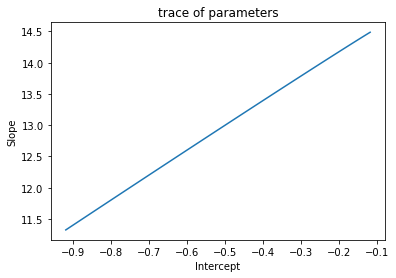

In [111]:
plt.title('trace of parameters')
plt.plot(mb_parameters[0,:],mb_parameters[1,:])
plt.xlabel('Intercept')
plt.ylabel('Slope')

Text(0,0.5,'Loss')

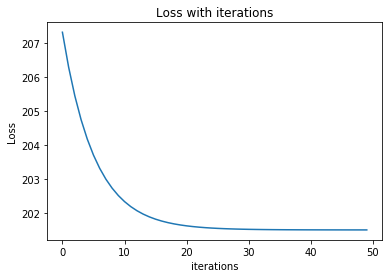

In [112]:
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),mb_loss.reshape(iterations))
plt.xlabel('iterations')
plt.ylabel('Loss')

Text(0,0.5,'Gradient')

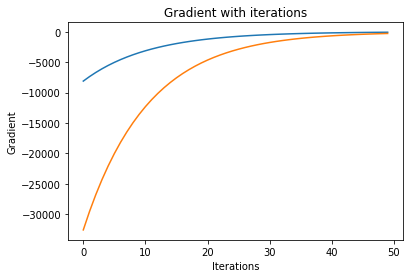

In [113]:
plt.title('Gradient with iterations')
plt.plot(np.arange(iterations),mb_grad[0,:].reshape(iterations),mb_grad[1,:].reshape(iterations))
plt.xlabel('Iterations')
plt.ylabel('Gradient')

Text(0.5,0,'Loss')

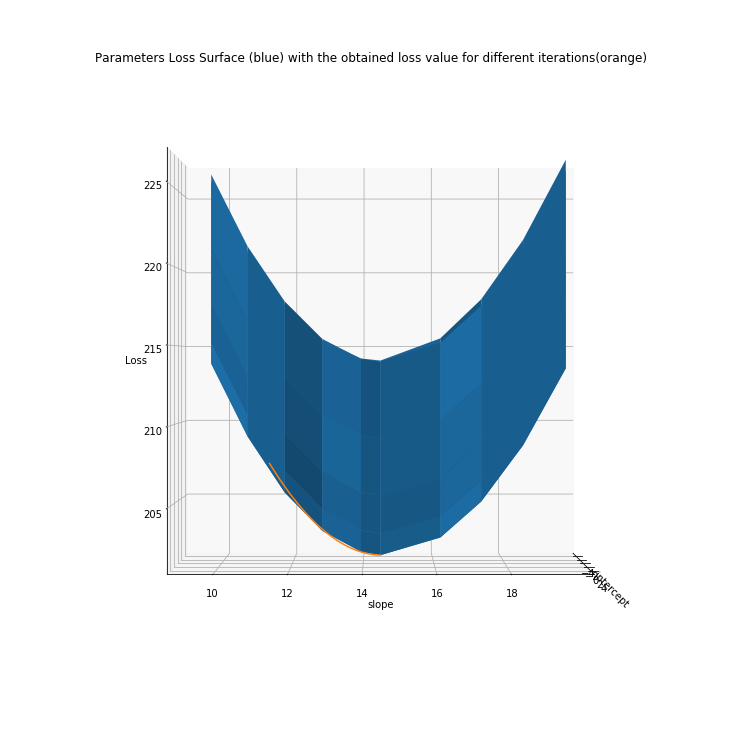

In [74]:
SIZE = 10
x = x.reshape(len(x),1) # reshaping x and y values to proper column vectors
y = y.reshape(len(y),1)
X_m = np.append(np.ones((len(x),1)),x,axis=1)
param_0 = np.linspace(mb_intercept - SIZE/2,mb_intercept + SIZE/2,SIZE)
param_0[SIZE//2] = mb_intercept
param_1 = np.linspace(mb_slope - SIZE/2,mb_slope + SIZE/2,SIZE)
param_1[SIZE//2] = mb_slope
mb_3d_loss = np.empty((SIZE,SIZE))
for i in np.arange(SIZE):
    for j in np.arange(SIZE):
        param_3d = np.array([param_0[i],param_1[j]]).reshape(2,1)
        mb_3d_loss[i,j] = (0.5 * np.sum(np.square(X_m.dot(param_3d)-y)))/len(x)
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.view_init(0,0) # these angles can be changed for a different view.
ax.plot_surface(param_0,param_1,mb_3d_loss)
ax.plot(np.squeeze(mb_parameters[0,:]),np.squeeze(mb_parameters[1,:]),np.squeeze(mb_loss))
ax.set_title('Parameters Loss Surface (blue) with the obtained loss value for different iterations(orange)')
ax.set_xlabel('intercept')
ax.set_ylabel('slope')
ax.set_zlabel('Loss')

Just like Stochastic gradient descent, We implemented two versions of mini batch SGD.

1. Where one iteration is equal to an epoch in which all the values in the dataset are evaluated. The above implementation corresponds to that.

2. Where one iterations means only a batch of data sets are evaluated. Below is an example of one such implementation.

In [75]:
def mb_gradient_descent2(x,y,b,w,lr,iters=1000,eps=0,batch_length = 0.1*len(x)): # arguments
    error_1 = np.finfo('float').max # initializing the error to maximum float value 
    loss = np.zeros([1,iters]) # loss matrix for all the iterations
    grad = np.zeros([2,iters]) # gradient values for each iteration
    x = x.reshape(len(x),1) # reshaping x and y values to proper row vectors
    y = y.reshape(len(y),1)
    X_m = np.append(np.ones((len(x),1)),x,axis=1) # adding the identity column to the x matrix 
    ret_params= np.zeros([2,iters])  # parameter values to be returned
    for i in np.arange(iters):
        start,end = getBatchIndex(i,batch_length,len(x)) #IMPORTANT Getting the start and the end index for the batch
        param = np.array([b,w]).reshape(2,1) # creating a theta vector 
        f = X_m[start:end].dot(param) #IMPORTANT calculating f. Notice the use of batch starting and ending indices.
        loss[:,i] = (0.5 * np.sum(np.square(f-y[start:end])))/batch_length # IMPORTANT calculating loss.  Notice the use of batch starting and ending indices.
        grad[:,i] = (X_m[start:end].T.dot(f-y[start:end])).reshape(2) # IMPORTANT calculating gradient.  Notice the use of batch starting and ending indices.
        b = b - lr*grad[0,i] # updating the parameters
        w = w - lr*grad[1,i]
        ret_params[:,i] = np.array([b,w]).reshape(2) # putting the updated values in the parameter matrix to be returned
        if( np.abs(loss[:,i] - error_1) <= eps): # checking the marginal improvement on the loss
            break
        error_1 = loss[:,i]
    return b,w,loss,grad,ret_params

Values obtained by Stochastic Gradient Descent 2
-0.108287417542 14.5137620819
Values obtained by Linear Regression
-0.106823564161 14.5151694796
CPU times: user 620 ms, sys: 0 ns, total: 620 ms
Wall time: 620 ms


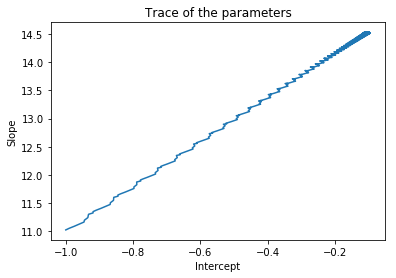

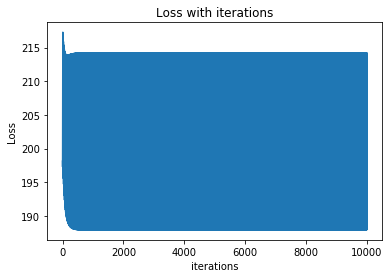

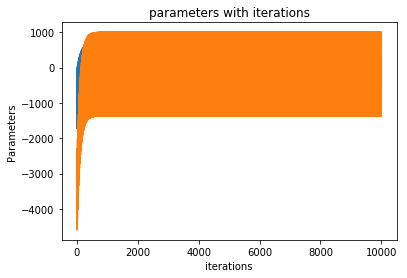

In [77]:
%%time
iterations =10000
mb2_intercept,mb2_slope,mb2_loss,mb2_grad,mb2_parameters = mb_gradient_descent2(x,y,-1,11,\
                                                                                       np.power(0.1,5),\
                                                                                       iters=iterations,batch_length=batch_length)

print("Values obtained by Stochastic Gradient Descent 2")
print(mb2_intercept,mb2_slope)
print("Values obtained by Linear Regression")
print(intercept,slope)

plt.figure()
plt.title('Trace of the parameters')
plt.plot(mb2_parameters[0,:],mb2_parameters[1,:])
plt.xlabel('Intercept')
plt.ylabel('Slope')


plt.figure()
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),mb2_loss.reshape(iterations))
plt.xlabel('iterations')
plt.ylabel('Loss')


plt.figure()
plt.title('parameters with iterations')
plt.plot(np.arange(iterations),mb2_grad[0,:],mb2_grad[1,:])
plt.xlabel('iterations')
plt.ylabel('Parameters')

As we can see, this implementation is faster than the other one but it gave fluctuated values for loss and parameters. From now on, whenever we refer to minibatch SGD, we refer to the first implementation.

###### <div class="alert alert-block alert-info">
<strong>Part 7.</strong> Compare the loss rate of the three approachs, Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent, by plotting in the same figure, the loss rate as a function of iterations. 


Comment the behavior of the three algorithms.
</div>

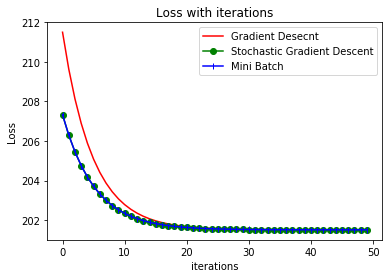

In [114]:
iterations = 50
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),gd_loss.reshape(iterations),'-r',sgd_loss.reshape(iterations),'-og',mb_loss.reshape(iterations),'|-b')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend(['Gradient Desecnt','Stochastic Gradient Descent','Mini Batch'])

It can be seen from this graph that the gradient descent algorithm takes a longer time to reach near it's result as compared to SGD and MiniBatch gradient descent. Whereas, SGD and MiniBatch seem to be performing the same. (Theoretically, this should not be the case. MiniBatch should be slower than SGD and faster than GD) 

***

## Distributed Mini-Batch Stochastic Gradient Descent
We're now ready to study the problem of distributed, mini-batch stochastic gradient descent. Clearly, so far we've worked with very small datasets: as a consequence it is hard to appreciate the computational bottleneck of serial implementations. But before we delve into an experimental setting, and try to spice things up with larger datasets, let's focus on the problem per se.

The problem statement is as follows: we need to design a distributed version of the algorithm we examined above, that is the Mini-Batch Stochastic Gradient Descent. In the interest of time, and also because in this laboratory we want to work with Apache Spark, we will look at **synchronous** distributed algorithms. Don'y worry, things will be much more clear in the next section!


The following references are a collection of pointers to real code, which essentially implement the ideas presented in the research paper we mentioned. Beware, this is Scala code, whereas we use Python. On another note, it is interesting to look at code that is meant to be integrated as a contribution to a popular open source software, such as Apache Spark, and in particular MLLib. This is in stark contrast to the "coding style" we adopt in this Notebook, which is to be considered experimental, and far from being compliant with any principled approach to software engineering.


#### References
* Parallelized Stochastic Gradient Descent: http://martin.zinkevich.org/publications/nips2010.pdf
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/ParallelizedSGD.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/SGDUpdater.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/test/scala/org/apache/spark/mllib/optimization/ParallelizedSGDSuite.scala

### Some useful hints to design your distibuted algorithm

#### Algorithm pseudo-code
In what follows, we outline the algorithm pseudo-code:

```python
for i in range(iterations)
  
  # Randomly partition the input, giving T examples to each machine.
  mini_batches = sample(input_data)

  # Initialize random paramters
  params = initialize
  
  # This part executes in parallel, on each of the k worker machines
  # This is essentially the same code as for the serial implementation
  # Indeed, we're working on an embarassingly parallel formulation
  for data in mini_batch: 
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
    
  # Here we aggregate from all machines, and compute the update for iteration i
  # The update is simply the average of all updates coming from each of the k worker machines
  Aggregate from all computers params = average(params_k)
```

#### Input data and parameters
As for the input data, we want to use the same procedure we used from the beginning of the Notebook: we use scikit learn to generate our $x$ and $y$.
Then, we have to find ways to **partition** this data across the machines we have in our cluster. The method ```sc.parallelize``` comes handy here.

Once we have a parallel collection, that takes the form of an ```RDD```, we'll have to ```sample``` from it, to create random mini batches, each of which will be used **independently** by each worker machine to process its own data. Be careful that here we want to **keep the data partitioning** of our original data.

Last but not least, we have to take care about the parameters! The initial parameter values, as well as any updates to them, must be shipped to all worker machines. There are various ways to do this, exploiting the great flexibility of Apache Spark. This data could be serialized and shipped along with the code each task should execute. However, a much more efficient method to do this is to exploit what we have learned in class, namely ```broadcast variables```. One might argue that for our simple Notebook, since the parameter vector is of size 2, this is not a big deal. However, for different scenarios, like big models, having an efficient primitive to ship a lot of data to workers is a big plus: remember that broadcast variables are sent to workers using a protocol very similar to BitTorrent, a famous peer-to-peer content distribution system.

#### Driver vs. workers

Now, to clarify even further what we expect from our Apache Spark program, here's some additional information about the roles of each component invovled in the execution of the pseudo-code outlined above.


Essentially, the ```driver``` machine (the one where the ```SparkContext``` is created), is the one responsible for executing the "serial" part of the algorithm: prepare and dispatch data, and wait for the contributions coming from all machines.


Instead, the ```worker``` machines receive their task to execute, proceed independently (some faster than others), and send their updates to the driver. The driver will **wait for all updates from workers** before proceeding with the final aggregation.

<div class="alert alert-block alert-info">
<strong>Part 8.</strong> Implement our version of Mini-Batch, Stochastic Gradient Descent, as a **distributed** algorithm.

    
The output of the cell contains the following information:
<ul>
<li> The values of the paramters obtained through Gradient Descent optimization </li>
<li> The values of the paramters obtained with the above cell, using scikitlearn </li>
<li> A plot of the loss versus iterations </li>
<li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

We created a function that runs inside each worker (Mini_batch_func) over every partition. It should be noted that the worker applies MiniBatch gradient descent on all it's partition. It should be noticed that we work with the same philosophy as the first implementation of normal Mini Batch gradient descent (i.e. each iteration corresponds to the calculation of gradient over the entire dataset)

In [79]:
sc

<SparkContext master=spark://spark-master0-23043-prod:7077 appName=pyspark-shell>

In [80]:
def Mini_batch_func(iterator): # Function that runs inside every worker on each partition.
    b = bc_params.value[0] # taking the values of intercept, slope, learning rate and the batch length from all the broadcasted values.
    w = bc_params.value[1]
    lr = bc_params.value[2]
    batch_length = bc_params.value[3]
    param = np.array([b,w]).reshape(2,1) # making a parameters vector
    g = np.zeros((2)) # a gradient vector
    l = np.zeros((1)) # loss value
    lst = list(iterator) # converting the input values into a list (for iteration purposes)
    x = np.array([lst[i][0] for i in np.arange(len(lst))]).flatten() # in the input (x,y) -> x corresponds to the first value of each entry
    y = np.array([lst[i][1] for i in np.arange(len(lst))]).flatten().reshape(len(x),1) # in the input (x,y) -> y corresponds to the second value in each entry
    X_m = np.append(np.ones((len(x),1)),x.reshape(len(x),1),axis=1) # adding the identity column to the x matrix 
    iters=int(len(x)/batch_length) if (len(x)%batch_length == 0) else int(len(x)/batch_length)+1 # number of slices when input is divided 
    for i in np.arange(iters):
        start,end = getBatchIndex(i,batch_length,len(x)) # calculating start and end index for this iterations
        f = X_m[start:end].dot(param) #calculating F
        g =  X_m[start:end].T.dot(f-y[start:end]).reshape(2) # calculating gradient
        l += 0.5 * np.sum(np.square(f-y[start:end])) #calculating loss
        w -= lr*g[1]
        b -= lr*g[0]
    l/=len(x) #normalizing the loss
    return [('w',w),('b',b),('l',l),('g',g)] #the return values include intercept,slope,loss,gradient

In [81]:
#Initial parameters
w= 11.0
b= -0.12
lr = np.power(0.1,4)
iterations = 50
er = np.power(0.1,10)
batch_size = 100
bc_params = sc.broadcast([b,w,lr,batch_size]) # broadcasting intercept, slope, learning rate and batch size

In [82]:
%%time
data = [(x[i],y[i]) for i in np.arange(len(x))]
data_ps = sc.parallelize(data,6) #parallelizing data and dividing it into 6 partitions, as we have 6 cores and two workers (3 cores / worker)
#iterations *= (int(len(x)/batch_size) if (len(x)%batch_size == 0) else int(len(x)/batch_size)+1)
dist_loss = np.zeros([1,iterations]) # loss matrix for all the iterations
grad = np.zeros([2,iterations]) # gradient values for each iteration
x = x.reshape(len(x),1) # reshaping x and y values to proper row vectors
y = y.reshape(len(y),1)
X_m = np.append(np.ones((len(x),1)),x,axis=1) # adding the identity column to the x matrix 
ret_params= np.zeros([2,iterations])  # parameter values to be returned
for i in np.arange(iterations):
    result = data_ps.sample(False,1,seed=i).mapPartitions(Mini_batch_func).collect() # all the workers apply minibatch to all their partitions and the results are collected
    b = np.mean([result[i][1] for i in range(len(result)) if result[i][0]=='b']) # a mean is taken of all the intercepts, slopes, loss and gradients
    w = np.mean([result[i][1] for i in range(len(result)) if result[i][0]=='w'])
    dist_loss[:,i] = np.mean([result[i][1] for i in range(len(result)) if result[i][0]=='l'])
    grad[0,i] = np.array([result[i][1] for i in range(len(result)) if result[i][0]=='g'])[:,0].mean()
    grad[1,i] = np.array([result[i][1] for i in range(len(result)) if result[i][0]=='g'])[:,1].mean()
    ret_params[:,i] = np.array([b,w]).reshape(2)
    bc_params = sc.broadcast([b,w,lr,batch_size]) # the new values of slope and intercept need to be broadcasted
print("Values obtained by Distributed MiniBatch SGD")
print(b,w)
print("Values obtained by Linear Regression")
print(intercept,slope)

Values obtained by Distributed MiniBatch SGD
-0.106875508143 14.5146749541
Values obtained by Linear Regression
-0.106823564161 14.5151694796
CPU times: user 632 ms, sys: 128 ms, total: 760 ms
Wall time: 8.52 s


Text(0,0.5,'Slope')

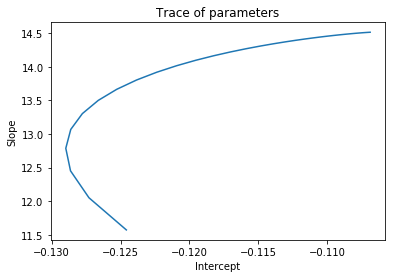

In [83]:
plt.title('Trace of parameters')
plt.plot(ret_params[0,:],ret_params[1,:])
plt.xlabel('Intercept')
plt.ylabel('Slope')

Text(0,0.5,'Loss')

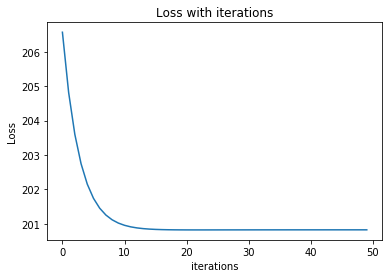

In [84]:
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),dist_loss.reshape(iterations))
plt.xlabel('iterations')
plt.ylabel('Loss')

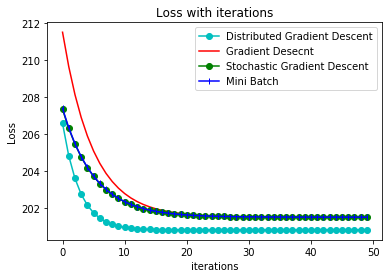

In [86]:
plt.title('Loss with iterations')
plt.plot(np.arange(iterations),dist_loss.reshape(iterations),'-oc',gd_loss.reshape(iterations),'-r',sgd_loss.reshape(iterations),'-og',mb_loss.reshape(iterations),'|-b')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend(['Distributed Gradient Descent','Gradient Desecnt','Stochastic Gradient Descent','Mini Batch'])

We chose 6 partitions because we have two workers and each worker has 3 cores allocated to it.

The data is broken into 6 RDDs, which can be determined by 'data_ps.getNumPartitions()' moreover, we can also see it in the jobs sections of the application in spark web master. The total number of tasks represents the number of RDD blocks our data is partitioned into.

If the data was stored in a CSV file in the HDFS. There would be additional shuffling time when we would have runned our task because the workers will ship the data, not locally present in them. However, this might also result in a reduction in 'Schedular Delay' time because now the task data would not need to be transported from driver to worker at each iteration. 

Since, we only use collect, the Spark webmaster shows only one job performed on all the data at each iterations.

A lot of time of a single job is spent on Schedular delay. Schedular delay is usually caused when because of shipping of task from the driver to the worker and the transfer of data from the worker back to the driver. 


To decrease that, we tried decreasing the fraction of data passed at each iteration. However, it did not have any significant results. Later on, we tried to increase the number of partitions from 6 to 36. This resulted in depression of Schedular delay however, resulted in inaccurate results and took a longer time overall.

<div class="alert alert-block alert-info">
<strong>Part 9.</strong> Comparison of serial vs. distributed algorithms.
</div>

Given all the implementation effort we did so far, this question is about an experimental study on scalability. Given input data sizes in the range $[10^2, 10^3, 10^4, 10^5]$, we collect the run-time and the loss rate at convergence for all variants of the serial algorithms and for the distributed one. Then, we produce a plot with 2 y-axis, one for the run-time, one for the loss rate, and one x-axis with the input data size.


We manually changed the size of data and checked the time and loss of all the algorithms. A Good idea would have been to run a script and do everything automatically. Unfortunately, we thought about it only after having done most of the work manually. In order to maintain the results, we stored them in a json file. which was later translated to the below cell.

In [120]:
loss = {'GD': {'3': 571.6257890554773,
  '2': 2172.7081361293112,
  '4': 201.5094920951075,
  '5': 201.5094920951075,
  '6': 6.5074588174533605e+96},
 'SGD': {'2': 2112.684021654393,
  '3': 553.6341722501304,
  '4': 201.51347410911075,
  '5': 198.1739140892473,
  '6': 199.81092224347458},
 'BGD': {'2': 1133.0977172710204,
  '3': 198.50995181936227,
  '4': 201.54155779085485,
  '5': 198.20024619112726,
  '6': 199.82695759390546},
 'Dist': {'2': 1997.3871587002604,
  '3': 386.5558090803219,
  '4': 200.82732673487328,
  '5': 198.14314629555224,
  '6': 2.4540645665249744e+120}}
times = {'GD': {'2': [0, 4],
  '3': [4, 4],
  '4': [0, 264],
  '5': [32, 296],
  '6': [1520, 14800]},
 'SGD': {'2': [76, 268],
  '3': [80, 1850],
  '4': [460, 16600],
  '5': [3950, 155000],
  '6': [29900, 145000]},
 'BGD': {'2': [8, 44],
  '3': [40, 276],
  '4': [52, 1330],
  '5': [232, 13300],
  '6': [1670, 134000]},
 'Dist': {'2': [68, 588],
  '3': [104, 460],
  '4': [112, 536],
  '5': [84, 1020],
  '6': [308, 5660]}}

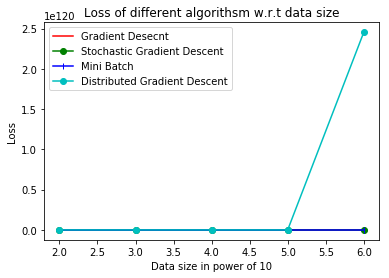

In [121]:
#import json
#with open('loss.json','r') as lfile:
#    loss = json.load(lfile)
#with open('times.json','r') as tfile:
#    times = json.load(tfile)
plt.plot([2,3,4,5,6],loss["GD"].values(),'-r')
plt.plot([2,3,4,5,6],loss["SGD"].values(),'-og')
plt.plot([2,3,4,5,6],loss["BGD"].values(),'|-b')
plt.plot([2,3,4,5,6],loss["Dist"].values(),'-oc')
plt.xlabel('Data size in power of 10')
plt.ylabel('Loss')
plt.title('Loss of different algorithsm w.r.t data size')
plt.legend(['Gradient Desecnt','Stochastic Gradient Descent','Mini Batch','Distributed Gradient Descent'])
#plt.subplot(1,2,2)

The above representation doesn't let us understand much. This is due to the fact that when the data is very large (i.e. 10<sup>6</sup>), Gradient descent and Distributed Gradient descent give exponential errors. We can understand the Data better if we set these values to zero and revisualize the data.

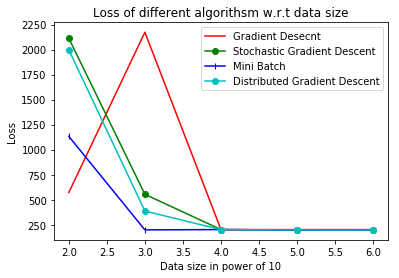

In [161]:
loss["GD"]["6"] = loss["GD"]["5"]
loss["Dist"]["6"] = loss["Dist"]["5"]
plt.plot([2,3,4,5,6],loss["GD"].values(),'-r')
plt.plot([2,3,4,5,6],loss["SGD"].values(),'-og')
plt.plot([2,3,4,5,6],loss["BGD"].values(),'|-b')
plt.plot([2,3,4,5,6],loss["Dist"].values(),'-oc')
plt.xlabel('Data size in power of 10')
plt.ylabel('Loss')
plt.title('Loss of different algorithsm w.r.t data size')
plt.legend(['Gradient Desecnt','Stochastic Gradient Descent','Mini Batch','Distributed Gradient Descent'])

Gradient descent anamolously shows a higher error when the data size is 10<sup>3</sup>.

However, when the data size is 10<sup>4</sup> and 10<sup>5</sup>, Distributed system gives the lowest error. (not talking about 10<sup>6</sup> since, we changed it for better visualization. For relatively small values of data, MiniBatch was found to be optimal.

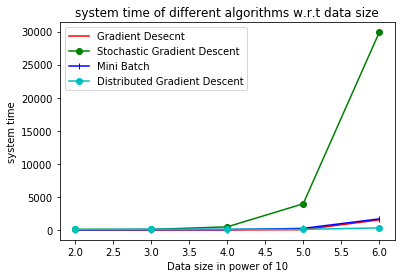

In [149]:
plt.xlabel('Data size in power of 10')
plt.ylabel('system time')
plt.title('system time of different algorithms w.r.t data size')
plt.plot([2,3,4,5,6],[x[0] for x in times["GD"].values()],'-r')
plt.plot([2,3,4,5,6],[x[0] for x in times["SGD"].values()],'-og')
plt.plot([2,3,4,5,6],[x[0] for x in times["BGD"].values()],'|-b')
plt.plot([2,3,4,5,6],[x[0] for x in times["Dist"].values()],'-oc')
plt.legend(['Gradient Desecnt','Stochastic Gradient Descent','Mini Batch','Distributed Gradient Descent'])

In order to better visualize the data we zoom in on it.

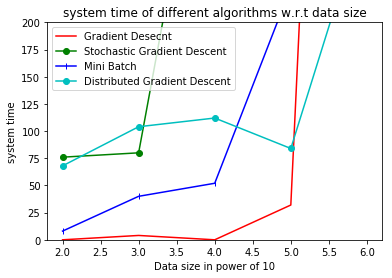

In [170]:
plt.xlabel('Data size in power of 10')
plt.ylabel('system time')
plt.title('system time of different algorithms w.r.t data size')
plt.plot([2,3,4,5,6],[x[0] for x in times["GD"].values()],'-r')
plt.plot([2,3,4,5,6],[x[0] for x in times["SGD"].values()],'-og')
plt.plot([2,3,4,5,6],[x[0] for x in times["BGD"].values()],'|-b')
plt.plot([2,3,4,5,6],[x[0] for x in times["Dist"].values()],'-oc')
plt.ylim(0,200)
plt.legend(['Gradient Desecnt','Stochastic Gradient Descent','Mini Batch','Distributed Gradient Descent'])

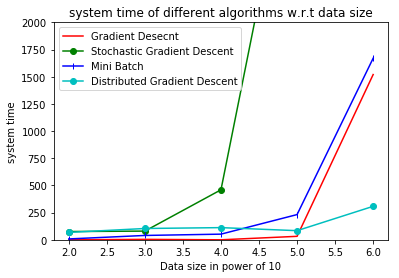

In [171]:
plt.xlabel('Data size in power of 10')
plt.ylabel('system time')
plt.title('system time of different algorithms w.r.t data size')
plt.plot([2,3,4,5,6],[x[0] for x in times["GD"].values()],'-r')
plt.plot([2,3,4,5,6],[x[0] for x in times["SGD"].values()],'-og')
plt.plot([2,3,4,5,6],[x[0] for x in times["BGD"].values()],'|-b')
plt.plot([2,3,4,5,6],[x[0] for x in times["Dist"].values()],'-oc')
plt.ylim(0,2000)
plt.legend(['Gradient Desecnt','Stochastic Gradient Descent','Mini Batch','Distributed Gradient Descent'])

It can be seen that for small amount of data, distributed algorithm is the slowest, whereas the gradient descent remains the fastest algorithm for small to relatively large amounts of data. Beware, this is computation time of the system and not the number of iterations it takes to converge to the result (in which case Gradient descent is the slowest as seen from the loss graph).

It is important to note that when the data size increases to 10<sup>6</sup>, distributed algorithm's time doesn't increase sharply; in contrast, to all the other algorithms.